### **3D Power Spectrum Computation Notebook**

Notebook with algorithm for numerically computing 3D power spectrum. Tested on uniformly distributed data and dark matter paticles. Cell below imports required packages and initializes catalog/cosmology objects for dark matter computation.

In [ ]:
import sys

fastpt_path = r"/global/u2/s/samgolds/FAST-PT/"
genericio_path = (r"/global/u2/s/samgolds/DC2-analysis/contributed/"
                  "nonlinear_bias/genericio/python/")
gcrcatalogs_path = r"/global/u2/s/samgolds/gcr-catalogs/"

sys.path.append(fastpt_path)
sys.path.append(genericio_path)
sys.path.append(gcrcatalogs_path)

import GCRCatalogs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pyccl
import sys
import genericio

from nbodykit.lab import *
from nbodykit import style

from scipy.constants import speed_of_light
from matplotlib.ticker import NullFormatter

sns.set(style='ticks')


%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'


# Load catalog and galaxy positions
cat_str = "baseDC2_snapshot_z1.01_v0.1"
cat_str = "baseDC2_snapshot_z0.15_v0.1_small"
cat = GCRCatalogs.load_catalog(cat_str)

dark_matter_file = ("/global/projecta/projectdirs/lsst/groups/CS/"
                    "cosmoDC2/Outer_snapshots/z1.01/m000.mpicosmo.247")

def get_catalog_cosmology(cat_str):
    """
    Helper function to return catalog cosmology object and redshift
    """
    
    cat = GCRCatalogs.load_catalog(cat_str)
    
    return cat.cosmology, cat.redshift

COSMO, Z_RED_SHIFT = get_catalog_cosmology(cat_str)
COSMO_CCL = pyccl.Cosmology(h=COSMO.h, sigma8=COSMO.sigma8,
                            Omega_g=COSMO.Ogamma0, Omega_k=COSMO.Ok0,
                            Omega_c=COSMO.Odm0, Omega_b=COSMO.Ob0,
                            n_s=COSMO.n_s, Neff=COSMO.Neff)

# Compute sigma chi
H0 = 71.0
SIGMA_Z = 0.05*(1+Z_RED_SHIFT)
SCALE_FACTOR = 1/(1+Z_RED_SHIFT)
H_Z = pyccl.background.h_over_h0(COSMO_CCL, SCALE_FACTOR)*H0

SIGMA_CHI = (speed_of_light/10**3)/H_Z*SIGMA_Z

cat_vals = cat.get_quantities(["position_x", "position_y", "position_z",
                                   "Mag_true_r_lsst_z0"])

#### **Numerically Compute and Average 3D Power Spectra:**

Define functions to numerically compute and average 3D power spectra using FFT.

In [2]:
def calculate_auto_pow_spec_3D(pos_grid, boxsize):
    """ 
    Calculates the 3D auto power spectrum from data on an N*N*N grid. Removes zero
    order Fourier mode.

    Parameters:
    pos_grid: N*N*N np array
    Containing number of elements in each cell
    boxsize: 3 elem numpy array
    Contains the x, y, and z box size 

    Returns:
    k_vals (np float array): array containing the wave numbers in Mpc^-1
    p_k (np float array): array containing the returned power spectrum values in
    Mpc^3
    """
    
    # Validate input format
    grid_shape = pos_grid.shape
    assert(len(set(grid_shape)) == 1), "Grid must have same dimensions for x, y, z"
    assert(len(boxsize)==3), "Boxsize must specify dimensions for x, y, and z"
    
    N = pos_grid.shape[0]

    x_width, y_width, z_width = boxsize

    # Convert grid to represent over_density
    n_tot = np.sum(pos_grid)
    p_bar = n_tot/N**3  # No. elements expected per bin
    p_bar_mat = p_bar*np.ones_like(pos_grid)
    
    delta = 1/p_bar*(pos_grid-p_bar_mat)

    # Perform fourier transform
    delta_k = np.fft.rfftn(delta)

    # Calculate power spectrum
    pow_spec = np.real(delta_k*np.conj(delta_k))/(N**6/(x_width*y_width*z_width))
    p_k = pow_spec.flatten()

    # Get frequency values
    delta_x = x_width/N # Width in Mpc of each cell
    delta_y = y_width/N
    delta_z = z_width/N
    
    f_value = np.fft.fftfreq(N)
    f_value_r = np.fft.rfftfreq(N)
    
    kx_mat = np.outer(np.ones(N), 2.0*np.pi*f_value/delta_x)
    ky_mat = np.outer(2.0*np.pi*f_value/delta_y, np.ones(N))
    fz_vec = 2*np.pi*f_value_r/delta_z;

    # Construct wavenumber tensor and compute norms
    tens_shape = (len(fz_vec), N, N)
    kx_tens = np.outer(np.ones(len(fz_vec)), kx_mat).reshape(tens_shape)
    ky_tens = np.outer(np.ones(len(fz_vec)), ky_mat).reshape(tens_shape)
    kz_tens = np.outer(fz_vec, np.ones((N, N))).reshape(tens_shape)

    k_tens = np.sqrt(kx_tens**2+ky_tens**2+kz_tens**2)
    k_vals = k_tens.flatten()

    assert(len(k_vals) == len(p_k))
    
    # Remove zero order mode on return
    return k_vals[1:], p_k[1:]


def average_pow_spec(k_vals, p_vals, n_bins):
    """
    Averages power spectrum into n_bins based on k
    
    Parameters:
    k_vals (np float array): array containing the unaverged wave numbers in 
    Mpc^-1
    p_k (np float array): array containing the unaveraged power spectrum values in
    Mpc^2
    n_bins (int): integer representing the number of bins to average values into

    Returns:
    averaged_k (np float array): array containing the averaged wave numbers in
    Mpc^-1
    averaged_p (np float array): array containing the averged power spectrum values in
    Mpc^2
    n_modes (np int array): array containing the number of Fourier modes in each bin of 
    averaged_k/averaged_p
    """

    averaged_p, averaged_k, binnumbers = scipy.stats.binned_statistic(k_vals, p_vals, 'mean', bins=n_bins)
    
    # Compute average wave number of each bin
    averaged_k = averaged_k+(averaged_k[1]-averaged_k[0])/2
    
    # Calculate n_modes from bin number
    n_modes = np.bincount(binnumbers)[1:]
    
    return averaged_k[:-1], averaged_p, n_modes

#### **Test Algorithm on Uniformly Sampled Data:**

Test the power spectrum computation on uniformly distributed data to ensure agreement with $\frac{1}{\overline{n}}$ expectation.

In [253]:
# Initialize uniformly distributed data and convert to a 3D grid
n_tot = 10**8
box_len = 13

x_data = np.random.uniform(0, box_len, n_tot)
y_data = np.random.uniform(0, box_len, n_tot)
z_data = np.random.uniform(0, box_len, n_tot)

N_bins = 128
xyz_array = np.histogramdd((x_data,y_data,z_data), bins=N_bins)[0]

# Compute and plot power spectrum
box_size = box_len*np.ones(3)
n_bar = n_tot/(box_len)**3

k, p_k = calculate_auto_pow_spec_3D(xyz_array, box_size)
k, p_k, n = average_pow_spec(k, p_k, 64)

Text(0, 0.5, '$P(k)$')

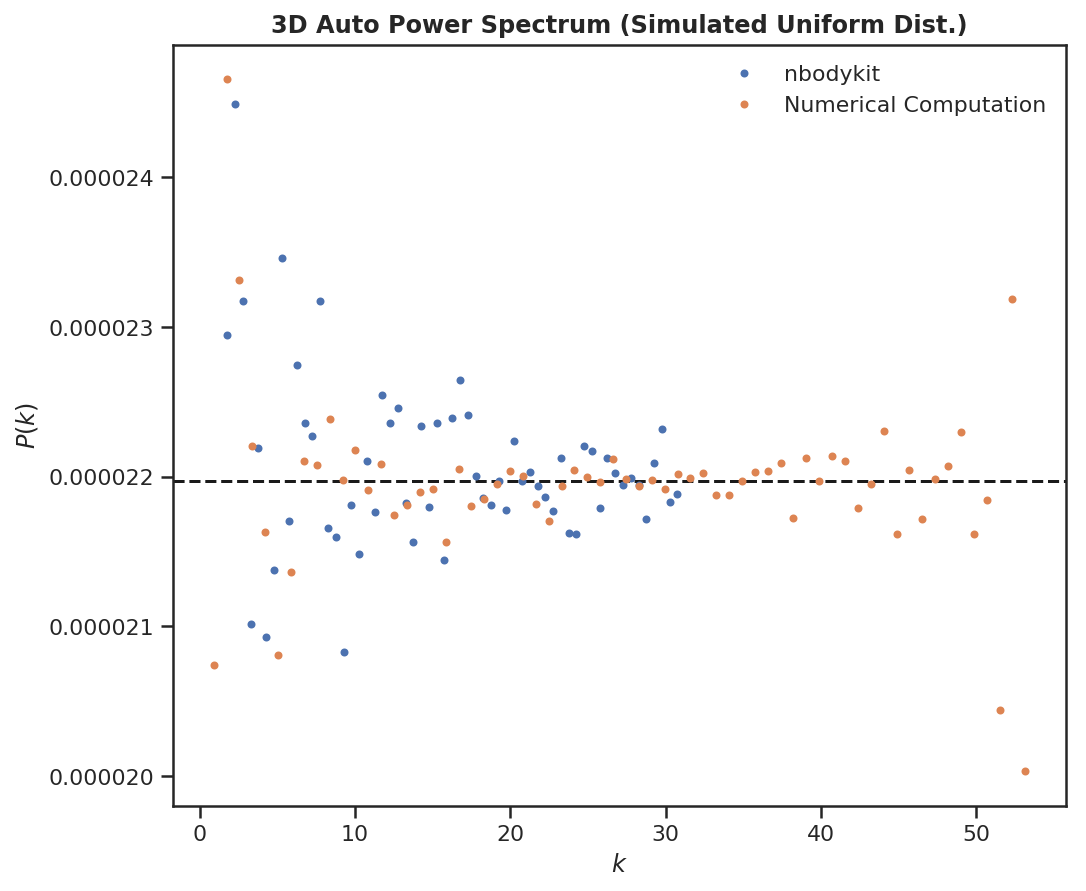

In [253]:
# Compute using nbodykit
rho = n_tot/N_bins**3
delta_xyz =1/rho*(xyz_array-rho*np.ones_like(xyz_array))
xyz_mesh = ArrayMesh(delta_xyz, BoxSize=box_size)
r_3d = FFTPower(xyz_mesh, mode='1d', dk=0.5, kmin=1)
P3D = r_3d.power

plt.figure(figsize=(8,7))
plt.axhline(1/n_bar, linestyle="--", color="k")
plt.plot(P3D['k'][1:], P3D['power'].real[1:], '.', label="nbodykit")
plt.plot(k, p_k, '.', label="Numerical Computation") 
plt.title("3D Auto Power Spectrum (Simulated Uniform Dist.)", fontweight="bold")
plt.legend(frameon=False)
plt.xlabel(r"$k$")
plt.ylabel(r"$P(k)$")

#### **Test Algorithm on Dark Matter Particles from OuterRim:**

Load dark matter paticles onto a $N^3$ mesh and compute 3D power spectrum. Particles come from a 3000 Mpc$^3$ simulation. Compare with CCL and asymptotic behavior with shotnoise.

In [ ]:
def conv_coord(q_data, N):
    """
    Helper function to convert from particle position to grid position
    """

    return np.floor(N/(3000)*q_data)

def load_dark_matter_positions(file_str, N):
    """
    Loads and applies preliminary filters to dark matter position data in Mpc
    from a specified catalog and then applies a Gaussian kernel

    Parameters:
    file_str (string): location of file to load dark matter particles from
    N (int):
    
    Returns:
    pos_mat (N*N*N array): grid containing number of particles in box 
    """
    
    # Load data from catalog using genericio
    x_data = np.array(genericio.gio_read(file_str, "x")[0])
    y_data = np.array(genericio.gio_read(file_str, "y")[0])
    z_data = np.array(genericio.gio_read(file_str, "z")[0])
    
    # Convert to grid positions
    x_c = conv_coord(x_data, N)
    y_c = conv_coord(y_data, N)
    z_c = conv_coord(z_data, N)
    
    return np.histogramdd((x_c,y_c,z_c), bins=np.outer(np.ones(3), np.arange(N+1)))[0]


def progress_bar(cur_val, final_val):
    """ 
    Function to keep track of progress during computations by displaying
    a progress bar

    Parameters:
    cur_val (int/float): current iteration/value calculation is on
    final_val (int/float): final iteration/value that calculation will take
    """

    bar_length = 20
    percent = float(cur_val) / final_val
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rProgress: [{0}]"
                     " {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()


# Load dark matter particle data from first file
print("Loading Dark Matter Particle Data")
N = 640

dm_grid = load_dark_matter_positions(dark_matter_file+"#0", N)

# Load dark matter particle data from remaining files
for i in range(1, 256):
    
    progress_bar(i, 256)
    
    dm_grid += load_dark_matter_positions(dark_matter_file+"#"+str(i), N)
    
    progress_bar(i, 256)

sys.stdout.flush()  # Clears output to prevent writing over progress bar
print("")

Loading Dark Matter Particle Data
Progress: [--->                ] 18%

In [235]:
# Compute then average power spectrum 
box_size = 3000*100/H0

k, p_k = calculate_auto_pow_spec_3D(dm_grid, box_size*np.ones(3))
k, p_k, n = average_pow_spec(k, p_k, 512)

# Compute using nbodykit
rho = np.sum(dm_grid)/N**3
delta_dm =1/rho*(dm_grid-rho*np.ones_like(dm_grid))
mesh = ArrayMesh(delta_dm, BoxSize=box_size)

r_3d = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.001)
P3D = r_3d.power

# Compute CCL MPS
P_lin = pyccl.linear_matter_power(COSMO_CCL, k, COSMO.scale_factor(Z_RED_SHIFT))
P_non_lin = pyccl.nonlin_matter_power(COSMO_CCL, k, COSMO.scale_factor(Z_RED_SHIFT))

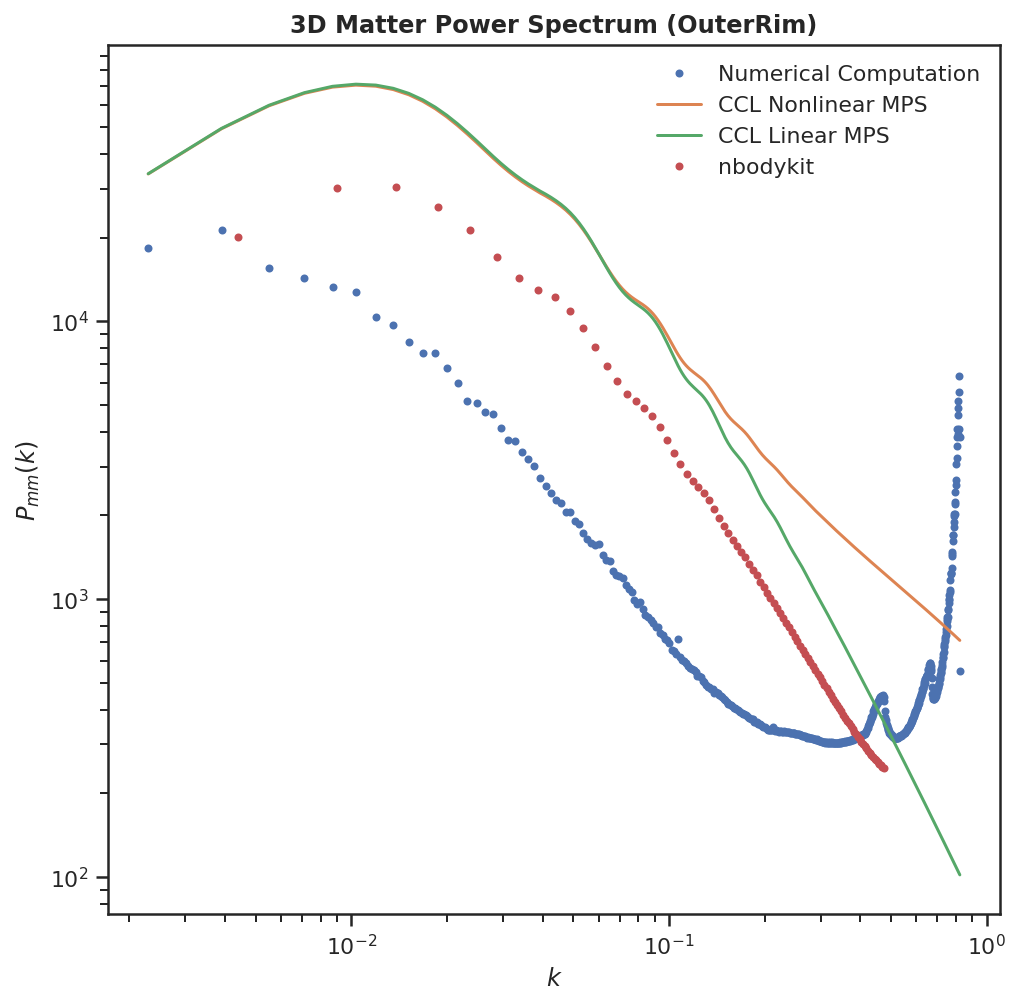

In [236]:
# Plot results

plt.figure(figsize=(8,8))

plt.plot(k, p_k, '.', label="Numerical Computation")
plt.plot(k, P_non_lin, label="CCL Nonlinear MPS")
plt.plot(k, P_lin, label="CCL Linear MPS")
plt.plot(P3D['k'], P3D['power'].real, '.', label="nbodykit")
plt.legend(frameon=False)
plt.xscale("log")
plt.yscale("log")

plt.title("3D Matter Power Spectrum (OuterRim)", fontweight="bold")
plt.xlabel(r"$k$")
plt.ylabel(r"$P_{mm}(k)$")

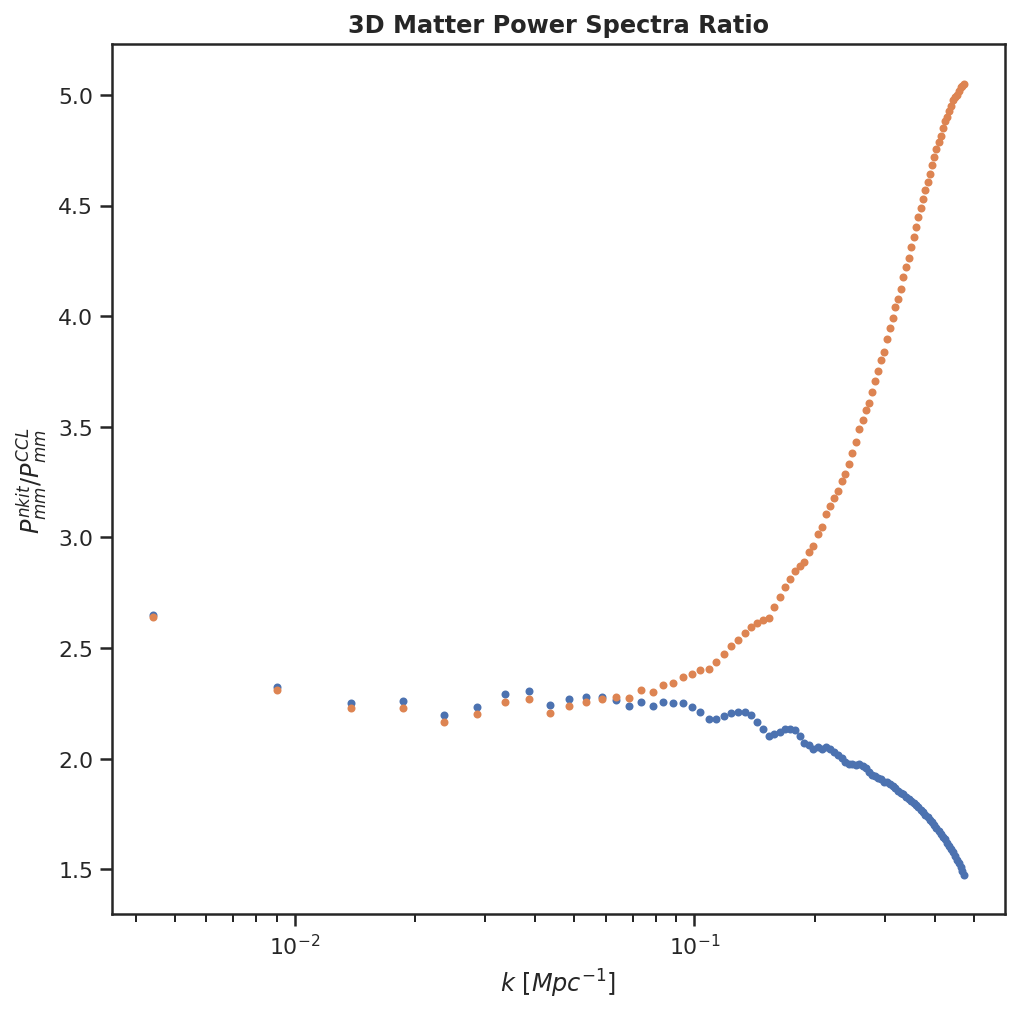

In [242]:
# Plot deviation from expectaiton 
P_lin_2 = pyccl.linear_matter_power(COSMO_CCL, P3D['k'], COSMO.scale_factor(Z_RED_SHIFT))
P_non_lin_2 = pyccl.nonlin_matter_power(COSMO_CCL, P3D['k'], COSMO.scale_factor(Z_RED_SHIFT))

plt.figure(figsize=(8,8))
plt.plot(P3D['k'], P_lin_2/P3D['power'].real, '.')
plt.plot(P3D['k'], P_non_lin_2/P3D['power'].real, '.')
plt.title("3D Matter Power Spectra Ratio", fontweight="bold")
plt.xlabel(r"$k \ [Mpc^{-1}]$")
plt.ylabel(r"$P_{mm}^{nkit}/P_{mm}^{CCL}$")

plt.xscale("log")